# Данный файл предназначен для небольшого EDA.
# Попробуем найти какие-то прикольные закономерности и что нибудь поделать с данными


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid", palette="pastel")
import math




##Поработаем с независимыми переменными , поищим преобразования и поработаем с выбросами

In [19]:
df_def = pd.read_excel("def.xlsx")
df_att = pd.read_excel("att.xlsx")
df_cost = pd.read_excel("cost.xlsx")
df_semi_merged = pd.merge(df_cost, df_att, how="inner", on=["Фамилия Имя"])
df = pd.merge(df_semi_merged, df_def, how="inner", on=["Фамилия Имя"])
df = df.drop_duplicates(subset=["Фамилия Имя"])
df=df[df["Позиция на поле"] != "Вратарь"]# бедняги вратари, но для них я не собрал данные отдельно ((((
#Тут у меня не совсем правильно переведенная лекскика была
df=df.rename(columns={"Прогрессивные успешные пасы":"Принятые игроком прогрессивные пасы"})
# так же стоит учесть и поменять название проекта , вся статистика собрана только по действиям в национальных чемпионатах
df



,Фамилия Имя,Возраст игрока,Национальность,Позиция на поле,Лига,Клуб,Стоимость,Голы,Ассисты,Голы с игры,...,Попытки отбора,успешные попытки отбора,количество остановок дриблинга+неудачных попыток остановаить дриблинг,неудачные попытки остновки дриблинга,Ошибки преведщие к ударам по воротам,Выносы из штрафной,Прерванные пасы,Прерванные удары,колво матчей (колво сыгранных минут/90),Прочитанных передач
0,Erling Haaland,24,Норвегия,Центральный нап.,АПЛ,Манчестер Сити,200,27,5,20,...,6,3,3,1,0,16,10,1,28.4,2
1,Jude Bellingham,21,Англия,Атак. полузащитник,Ла лига,Реал Мадрид,180,19,6,18,...,42,34,36,24,0,17,50,5,25.7,21
2,Kylian Mbappé,25,Франция,Центральный нап.,Ла лига,Реал Мадрид,180,27,7,21,...,4,1,9,5,0,2,4,0,24.0,2
3,Phil Foden,24,Англия,Правый Вингер,АПЛ,Манчестер Сити,150,19,8,19,...,31,20,31,18,1,18,30,0,31.7,13
4,Bukayo Saka,23,Англия,Правый Вингер,АПЛ,Арсенал,140,16,9,10,...,66,35,59,33,1,24,41,2,32.4,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,Habib Diarra,20,Сенегал,Атак. полузащитник,another league,Страсбур,20,3,1,2,...,30,23,33,24,0,15,19,4,25.6,17
361,Jack Hinshelwood,19,Англия,Центр. полузащитник,АПЛ,Брайтон энд Хоув Альбион,20,3,0,3,...,14,5,13,8,0,18,4,2,9.7,14
362,Alex Scott,21,Англия,Центр. полузащитник,АПЛ,Борнмут,20,1,1,1,...,24,15,28,16,2,18,10,4,11.3,12
363,Dango Ouattara,22,Буркина-Фасо,Левый Вингер,АПЛ,Борнмут,20,1,2,1,...,45,27,34,15,0,35,15,3,13.7,22


Попробуем найти графики по каждой зависимости, возможно у нас будет что-то интересное и мы сможем найти функции для доп фичей




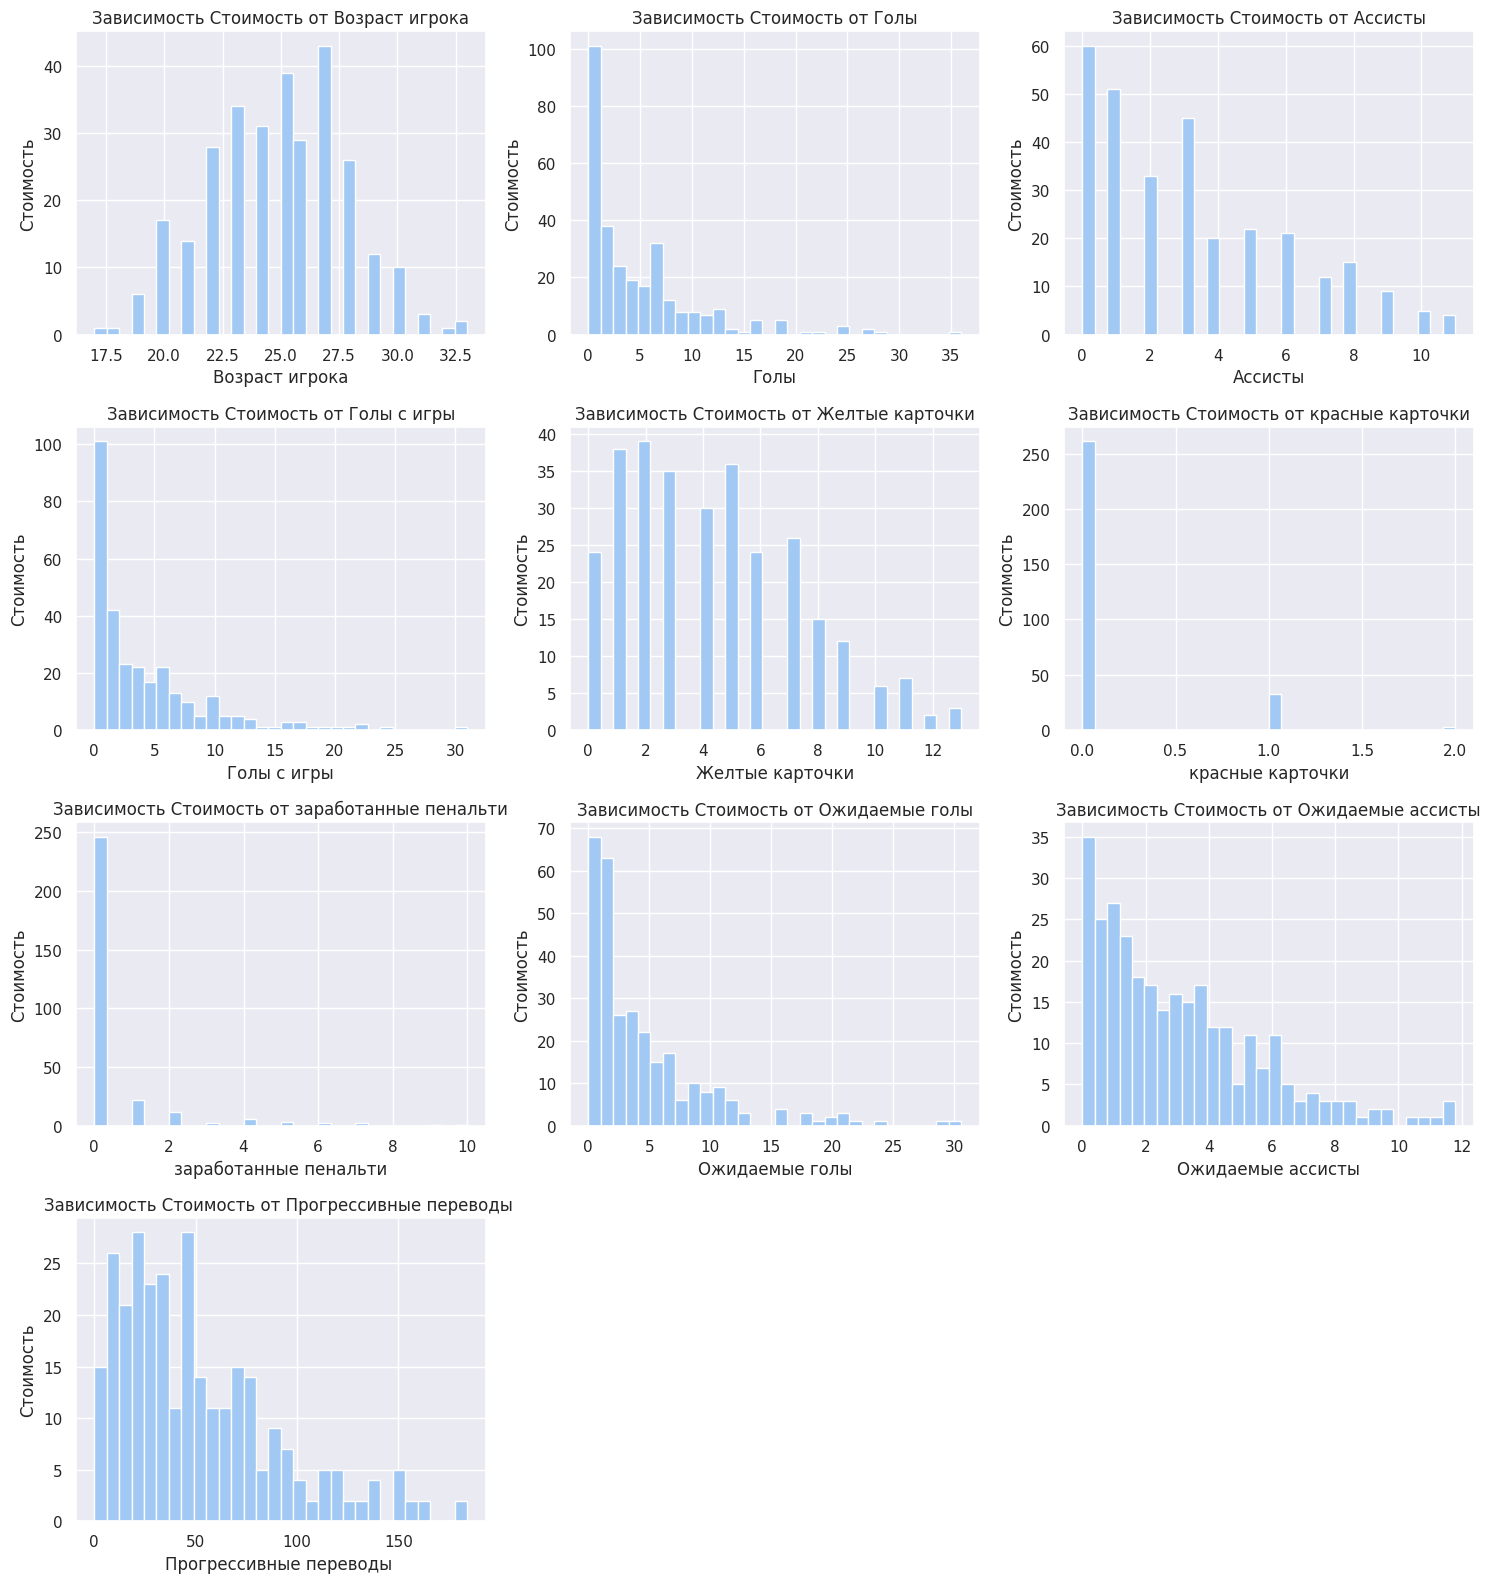

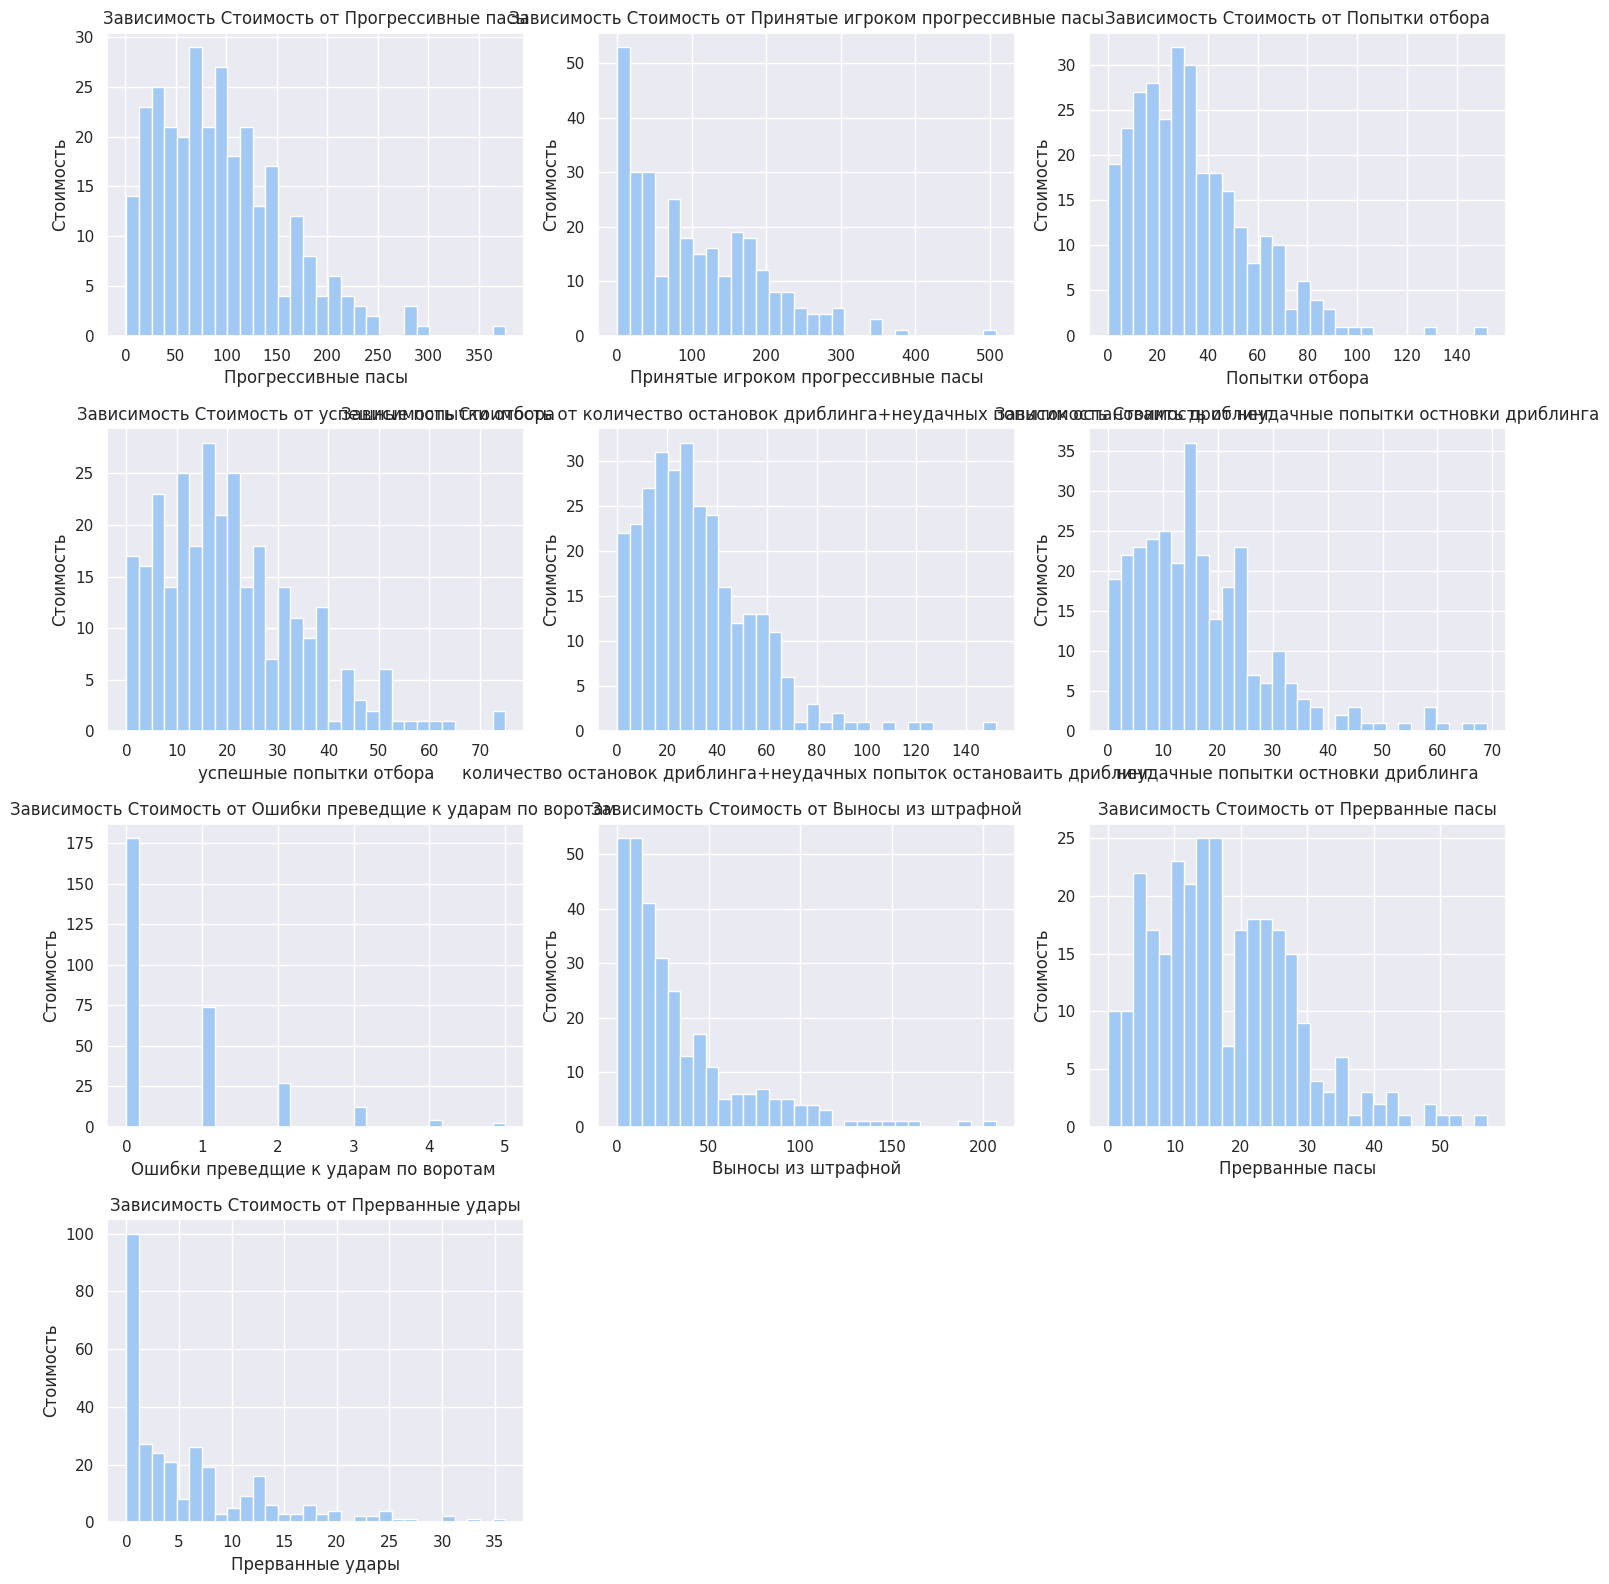

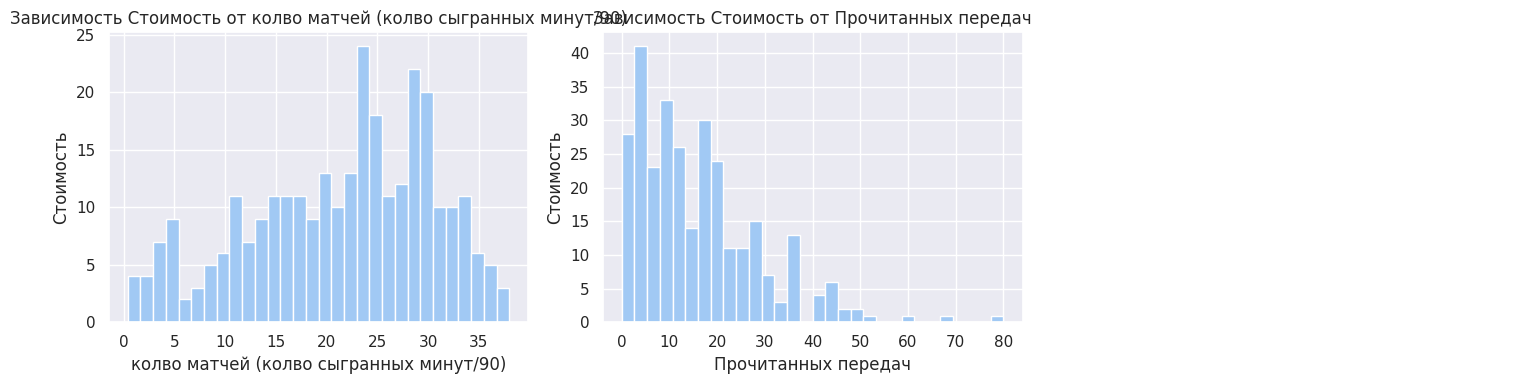

In [20]:
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
df_1 = df.drop(columns=categorical_columns).copy()
feat = [columns for columns in df_1.columns if columns != "Стоимость"]

chunk_size = 10
for start in range(0, len(feat), chunk_size):
    end = start + chunk_size
    subset = feat[start:end]
    n_cols = 3
    n_rows = -(-len(subset) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(subset):
        axes[i].hist(data=df_1, x=feature,bins=30)
        axes[i].set_title(f"Зависимость Стоимость от {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Стоимость")

    for j in range(len(subset), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


График стоимости в зависимости от возраста напоминает перевернутую параболу , значит возможно стоит сделать квадратичную функцию

Изначально я посмотрел на графки времени и у меня возникло подозрение ,что если мы наложим логорифм на эти данные , то у нас получится что-то типо параболы по данным , с которой также будет удобно поработать, ну и вроде так и получилось

Ну и раз получилось что-то типо параболы , попробовал бахнуть квадрат от логорифма времени

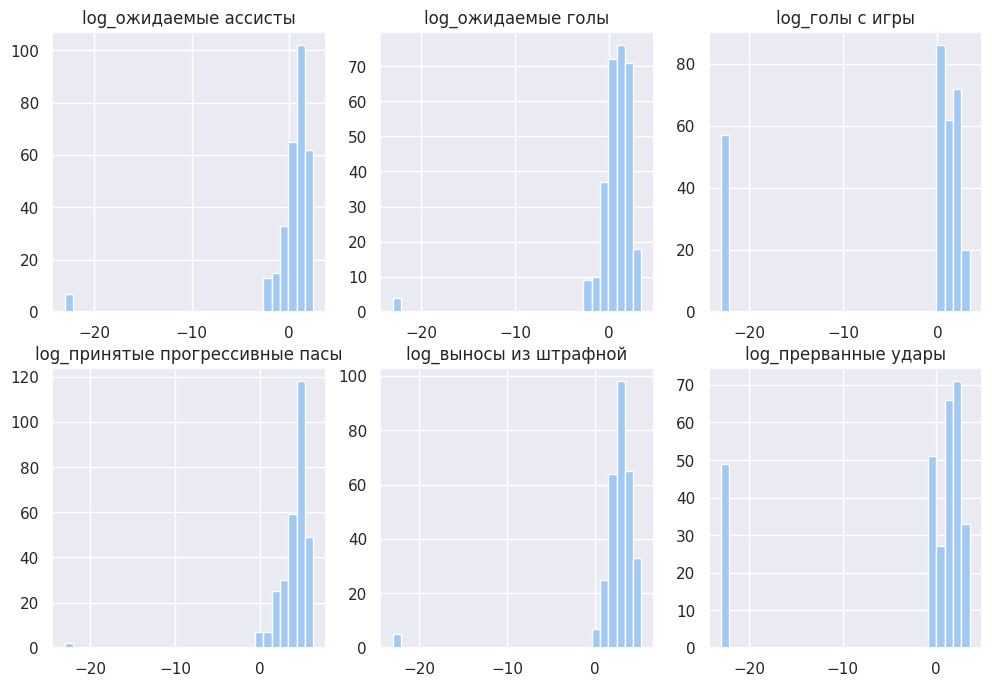

In [21]:
df["возраст^2"]=df["Возраст игрока"]**2 # создал эту переменную так как изначально посмотрел на график рассеяния между стоимостью и возрастом и решил что данное преобразование будет уместно
df["log_ожидаемые голы"]=np.log(df["Ожидаемые голы"]+1e-10)
df["log_голы с игры"]=np.log(df["Голы с игры"]+1e-10)
df["log_ожидаемые ассисты"]=np.log(df["Ожидаемые ассисты"]+1e-10)
df["log_принятые прогрессивные пасы"]=np.log(df["Принятые игроком прогрессивные пасы"]+1e-10)
df["log_выносы из штрафной"]=np.log(df["Выносы из штрафной"]+1e-10)
df["log_голы с игры"]=np.log(df["Голы с игры"]++1e-10)
df["log_прерванные удары"]=np.log(df["Прерванные удары"]+1e-10)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].hist(df["log_ожидаемые ассисты"], bins=30)
ax[0, 1].hist(df["log_ожидаемые голы"], bins=30)
ax[0, 2].hist(df["log_голы с игры"], bins=30)
ax[1, 0].hist(df["log_принятые прогрессивные пасы"], bins=30)
ax[1, 1].hist(df["log_выносы из штрафной"], bins=30)
ax[1, 2].hist(df["log_прерванные удары"], bins=30)
ax[0, 0].set_title("log_ожидаемые ассисты")
ax[0, 1].set_title("log_ожидаемые голы")
ax[0, 2].set_title("log_голы с игры")
ax[1, 0].set_title("log_принятые прогрессивные пасы")
ax[1, 1].set_title("log_выносы из штрафной")
ax[1, 2].set_title("log_прерванные удары")
plt.show()




Тут мы видим , что в целом даныне стали более или менее нормально распределенными , однако значения , которые изначально были =0 и мы их сделали 1e-10, скорее всего буду выбросными , однако можно будет сравнить где меньше выбросов , в изначальных данных или в тех что мы получили


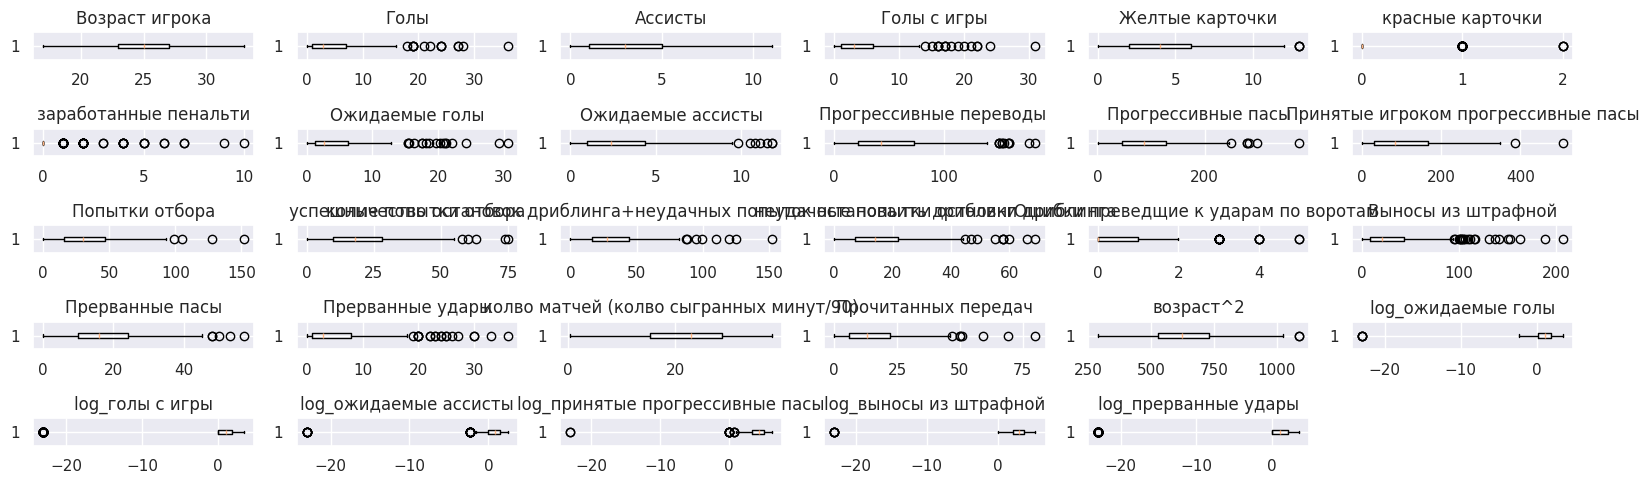

Количество выбросов по столбцу Возраст игрока: 0
Количество выбросов по столбцу Голы: 14
Количество выбросов по столбцу Ассисты: 0
Количество выбросов по столбцу Голы с игры: 16
Количество выбросов по столбцу Желтые карточки: 3
Количество выбросов по столбцу красные карточки: 36
Количество выбросов по столбцу заработанные пенальти: 51
Количество выбросов по столбцу Ожидаемые голы: 17
Количество выбросов по столбцу Ожидаемые ассисты: 7
Количество выбросов по столбцу Прогрессивные переводы : 11
Количество выбросов по столбцу Прогрессивные пасы: 6
Количество выбросов по столбцу Принятые игроком прогрессивные пасы: 2
Количество выбросов по столбцу Попытки отбора: 4
Количество выбросов по столбцу успешные попытки отбора: 5
Количество выбросов по столбцу количество остановок дриблинга+неудачных попыток остановаить дриблинг: 8
Количество выбросов по столбцу неудачные попытки остновки дриблинга: 10
Количество выбросов по столбцу Ошибки преведщие к ударам по воротам : 18
Количество выбросов по 

In [22]:
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
df_1 = df.drop(columns=categorical_columns).copy()
features_1=([columns for columns in df_1.columns if columns not in ["Стоимость"]])
fig, ax = plt.subplots(5,6 , figsize=(16, 5))
for i in range(5):
    for j in range(6):
        index = i * 6 + j
        if index < len(features_1):
            ax[i, j].set_title(features_1[index])
            ax[i, j].boxplot(df[features_1[index]], vert=False)
        else:
            ax[i, j].axis("off")

plt.tight_layout()
plt.show()

for feqt in features_1:
    Q1 = df_1[feqt].quantile(0.25)
    Q3 = df_1[feqt].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    outliers = df_1[(df_1[feqt] > upper_bound) | (df_1[feqt] < lower_bound)]
    num_outliers = len(outliers)
    print(f"Количество выбросов по столбцу {feqt}: {num_outliers}")


Тут видно,что визуальный анализ не очень нам помог, и прологорифмировав голы с игры, прерванные удары , мы сильно увеличили количество выбросов, и я решил что в дальнейшем уберу эти штуки , так как у логорифмирования смещенных данных есть плюсы в виде меньшей вариантивности и большей линейной зависимости, но такое увеличение выбросов не очень хорошо скажется, мне кажется

In [23]:
df=df.drop(columns=['log_голы с игры','log_прерванные удары'])

## Посмотрим что там у нас с Стоимостью


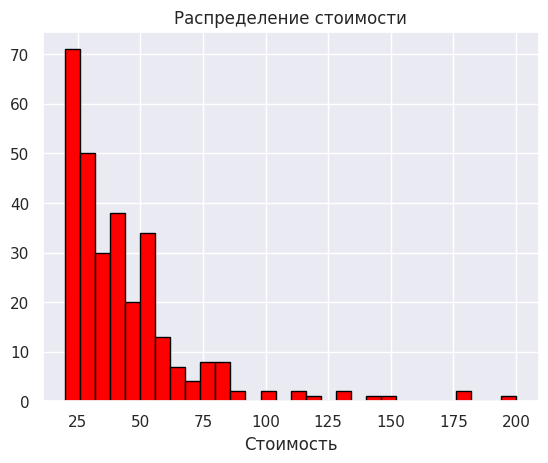

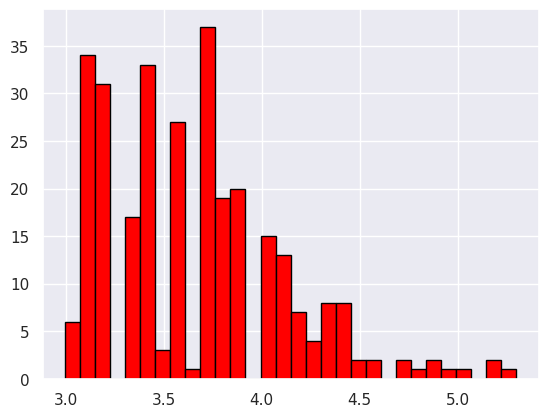

In [24]:
plt.hist(df["Стоимость"],bins=30,edgecolor="black",color="red")
plt.xlabel("Стоимость")
plt.title("Распределение стоимости")
plt.show()
# просто рассмотрим как будут распределены данные при log
df["log_Стоимость"]=np.log(df["Стоимость"]+1e-10)
plt.hist(df["log_Стоимость"],bins=30,edgecolor="black",color="red")
plt.show()

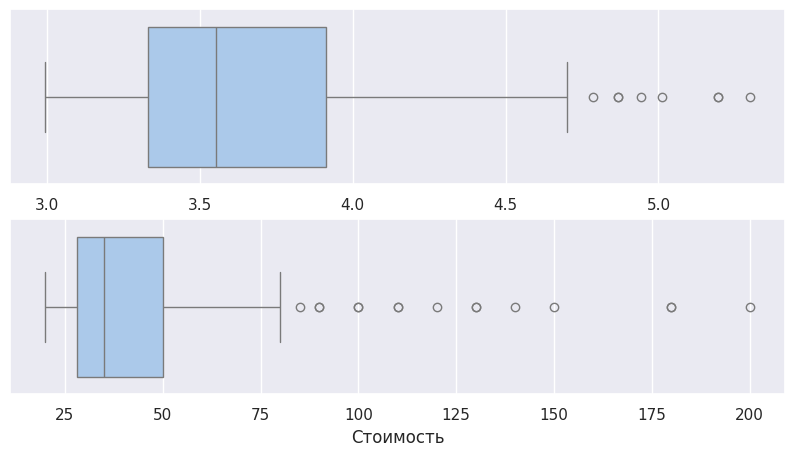

Количество выбросов по столбцу Стоимость: 15
Количество выбросов по столбцу log_Стоимость: 8


In [25]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))
sns.boxplot(x=df["log_Стоимость"], ax=ax[0], vert=False)
sns.boxplot(x=df["Стоимость"], ax=ax[1], vert=False)
plt.show()
lst=["Стоимость","log_Стоимость"]
for feqt in lst:
    Q1 = df[feqt].quantile(0.25)
    Q3 = df[feqt].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    outliers = df[(df[feqt] > upper_bound) | (df[feqt] < lower_bound)]
    num_outliers = len(outliers)
    print(f"Количество выбросов по столбцу {feqt}: {num_outliers}")
df=df.drop(columns=["log_Стоимость"])


Выбросов конечно стало поменьше ,но

Прям улучшения в данных я не увидел, чего-то даже немного похожего на нормальность тут не наблюдается, так что наверное не буду я логарифмировать стоимость

## кореляционная матрица


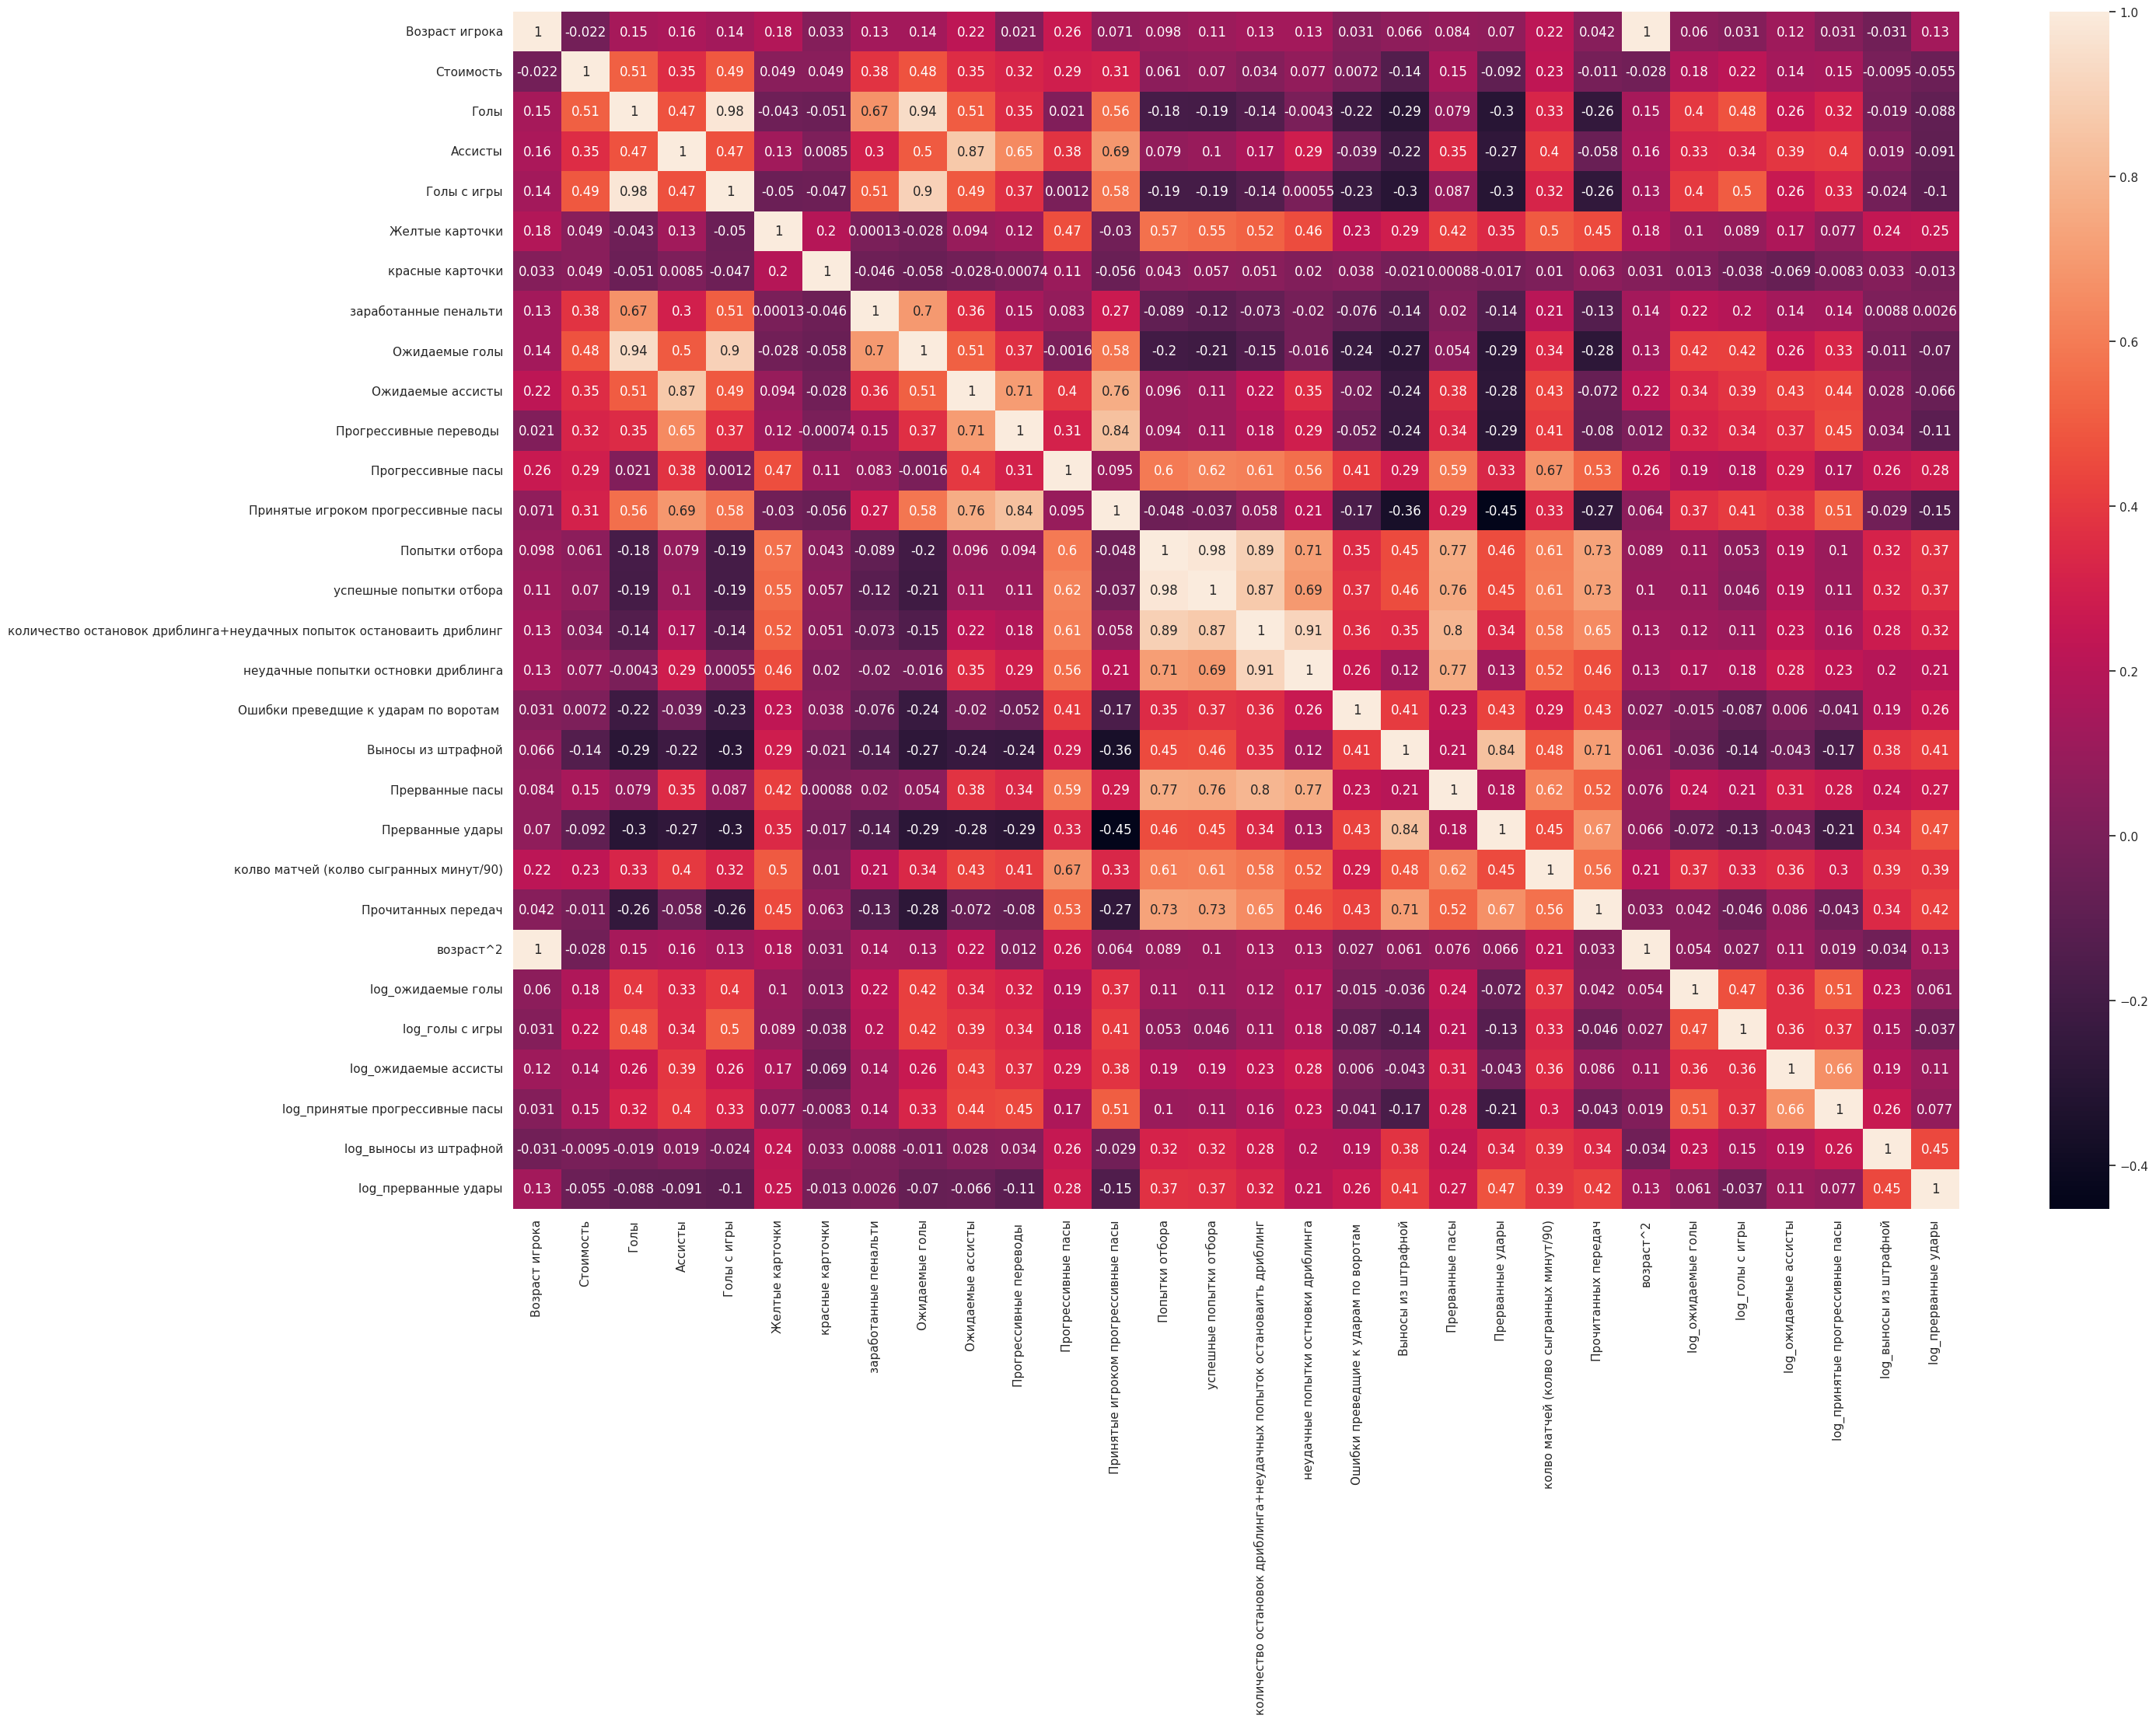

In [26]:
matrix=df_1.corr()
figure=plt.figure(figsize=(30,20))
sns.heatmap(matrix,annot=True)
plt.show()

Тут как будто можно заметить, что данные поделены на две группы , а именно : ***1 группа*** - метрики связаныне с действиями полузащитников и атакующих игроков,***2 группа***-метрики связаныне с оборонительными действиями.
В целом это укладывается в футбол.Чаще всего защитники занимаются чисто защитой и думают в основном об этом, в то время как нападающие и полузащитники взаимозаменяемы по своему функционалу.


Возможно после того, как я прсомотрел корреляционную матрицу , скорее всего лучше всего было бы разделить мой анализ на атакующих/ полузащитникок и защитников, но давайте попробуем провести дальнейший анализ без разделения на подаыборки по позициям

## Давайте посмотрим на среднеее,дисперсию ,минимумы и прочее, что включается в describe()



In [27]:
df.describe()

,Возраст игрока,Стоимость,Голы,Ассисты,Голы с игры,Желтые карточки,красные карточки,заработанные пенальти,Ожидаемые голы,Ожидаемые ассисты,...,Выносы из штрафной,Прерванные пасы,Прерванные удары,колво матчей (колво сыгранных минут/90),Прочитанных передач,возраст^2,log_ожидаемые голы,log_ожидаемые ассисты,log_принятые прогрессивные пасы,log_выносы из штрафной
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,2.970000e+02,297.000000,297.000000
mean,24.855219,43.579125,4.868687,3.188552,4.410774,4.292929,0.131313,0.457912,4.540741,3.043771,...,32.703704,17.255892,5.996633,21.412795,16.030303,626.377104,0.608583,1.152005e-01,3.889913,2.537487
std,2.936705,25.780151,5.739232,2.880175,4.925076,3.035552,0.367050,1.360301,5.092694,2.568212,...,34.496961,10.685389,6.838631,9.048483,12.924512,146.381902,3.013665,3.772349e+00,2.594879,3.530457
min,17.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.400000,0.000000,289.000000,-23.025851,-2.302585e+01,-23.025851,-23.025851
25%,23.000000,28.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.200000,1.000000,...,9.000000,10.000000,1.000000,15.200000,6.000000,529.000000,0.182322,1.000000e-10,3.401197,2.197225
50%,25.000000,35.000000,3.000000,3.000000,3.000000,4.000000,0.000000,0.000000,2.700000,2.400000,...,21.000000,16.000000,3.000000,23.000000,13.000000,625.000000,0.993252,8.754687e-01,4.430817,3.044522
75%,27.000000,50.000000,7.000000,5.000000,6.000000,6.000000,0.000000,0.000000,6.300000,4.400000,...,43.000000,24.000000,8.000000,28.700000,22.000000,729.000000,1.840550,1.481605e+00,5.111988,3.761200
max,33.000000,200.000000,36.000000,11.000000,31.000000,13.000000,2.000000,10.000000,30.600000,11.800000,...,207.000000,57.000000,36.000000,38.000000,80.000000,1089.000000,3.421000,2.468100e+00,6.230481,5.332719


В целом все норм, единственное что сильно смущает так это минимальные значения в логорифмических данных

In [28]:
lst=df.describe(include="object").columns
print(df["Лига"].value_counts())
nationality_counts = df['Национальность'].value_counts()
filtered_nationalities = nationality_counts[nationality_counts > 1]
print(filtered_nationalities)
print(df["Позиция на поле"].unique())



Лига
АПЛ               133
another league     42
Бундеслига         36
Ла лига            35
Серия А            32
Лига 1             19
Name: count, dtype: int64
Национальность
Англия                       54
Франция                      30
Бразилия                     25
Испания                      19
Германия                     18
Италия                       17
Нидерланды                   13
Португалия                   13
Аргентина                    11
Марокко                       7
Бельгия                       6
Дания                         5
Соединенные Штаты Америки     5
Кот-д'Ивуар                   5
Шотландия                     5
Нигерия                       5
Швеция                        4
Эквадор                       4
Уругвай                       3
Сенегал                       3
Австрия                       3
Япония                        3
Колумбия                      3
Камерун                       2
Алжир                         2
Швейцария             

Хотя мы и не использовали вратаря , позиций на поле все равно получилось 11 , так как в футболе считается что чистый форвард( центральный нап) и оттянутый форвард( оттянутый нап) это разные позиции. И в действительности это так, разные позиции с ранзным функционалом


Тут на раннем этапе мы видим,что большинство игроков из АПЛ. Изначально было предположение, что в англии очень перегрет рынок игроков , и даже средние игроки стоят больше, чем если бы они играли в другой лиге . Возможно это мини подтверждени

## Подготовим данные уже для непосредственной загрузки в модель


Сделаем из наших категориальных переменных dummy переменные


In [29]:
df_done_for_model=pd.get_dummies(data=df,columns=["Национальность","Позиция на поле","Лига","Клуб"],drop_first=True)
df_done_for_model= df_done_for_model.sample(frac=1).reset_index(drop=True)

Теперь вроде наши данные готовы к загрузке в модель

сохраним их в отдельный excel файл, чтобы было легче дальше работать с готовыми данными и завершить этот ноутбук


In [30]:
df_done_for_model.to_excel("done_data_for_metrics_1.xlsx")